In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
import datetime
import matplotlib.pyplot as plt

In [2]:
def tune_hyper(x_set,y_set,required_features):
    size=np.linspace(0.70, 0.95, 200).tolist()
    alp =np.logspace(-1, 1, 200).tolist()
    alp.append(0)
    column_names = ["trainsize", "alpha", "RMSE","MAE"]
    data =[]
    for i in size:
        num_train=int(i*len(x_set))
        x_train = x_set[0:num_train].copy()
        x_test = x_set[num_train:(len(x_set)-1)].copy()
        scaler = StandardScaler().fit(x_train)
        x_train[required_features] = scaler.transform(x_train[required_features]).copy()
        x_test[required_features] = scaler.transform(x_test[required_features]).copy()
        y_train = y_set[0:num_train].copy()
        y_test = y_set[num_train:(len(y_set)-1)].copy()
        for j in alp:
            model = Ridge(alpha=j)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            rmse=mean_squared_error(y_test, y_pred, squared=False)
            mae=mean_absolute_error(y_test, y_pred)
            data.append([i,j,rmse,mae])
    df = pd.DataFrame(data, columns=column_names)    
    return df

In [3]:
required_features = ['open_bitcoin','open_eth','open_bnb','open_ada','value_number_transaction','value_number_address','value_transaction_second','value_total_bitcoin','value_hash_rate']
output_label = ['close_bitcoin']

In [4]:
bitcoin = pd.read_pickle("../data/cleaned/bitcoin_cleaned.pkl")
x_set=bitcoin[required_features].copy()
y_set=bitcoin[output_label].copy()

In [5]:
df=tune_hyper(x_set,y_set,required_features)
tuned_trainsize=df[df.RMSE == df.RMSE.min()].trainsize.values
tuned_alpha=df[df.RMSE == df.RMSE.min()].alpha.values
tuned_trainsize2=df[df.MAE == df.MAE.min()].trainsize.values
tuned_alpha2=df[df.MAE == df.MAE.min()].alpha.values

In [6]:
num_train=int(tuned_trainsize[0]*len(x_set))
x_train = x_set[0:num_train].copy()
scaler = StandardScaler().fit(x_train)
x_train[required_features] = scaler.transform(x_train[required_features]).copy()
x_test = x_set[num_train:(len(x_set)-1)].copy()
x_test[required_features] = scaler.transform(x_test[required_features]).copy()
y_train = y_set[0:num_train].copy()
y_test = y_set[num_train:(len(y_set)-1)].copy()

In [7]:
model = Ridge(alpha=tuned_alpha[0])
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
rmse=mean_squared_error(y_test, y_pred, squared=False)
r2=r2_score(y_test, y_pred)

In [8]:
li_coef = pd.Series(model.coef_[0], index = x_train.columns)

print("Feature name\n", x_train.columns)
print("Model Coefficients\n", model.coef_)
print("Root Mean Squared Error:", mean_squared_error(y_test, y_pred,squared=False))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Coefficient of Determination:", r2_score(y_test, y_pred))

Feature name
 Index(['open_bitcoin', 'open_eth', 'open_bnb', 'open_ada',
       'value_number_transaction', 'value_number_address',
       'value_transaction_second', 'value_total_bitcoin', 'value_hash_rate'],
      dtype='object')
Model Coefficients
 [[ 1.99738644e+04 -4.10667089e+02 -3.45331502e+02  8.14851036e+01
   2.24094930e+02 -2.43044613e+02 -3.79413803e+01  4.67147115e+02
  -2.45426281e+00]]
Root Mean Squared Error: 1279.703743596288
Mean Absolute Error: 903.6571009632629
Coefficient of Determination: 0.9074496544582502


In [9]:
y_result = y_test.copy()
temp = y_pred.tolist()
y_result["close_bitcoin_pred"] = [np_float[0] for np_float in temp]
y_result.rename(columns={"close_bitcoin":"close_bitcoin_true"},inplace=True)
temp2 = bitcoin["datetime"].copy()
y_result = pd.merge(y_result, temp2, left_index=True, right_index=True)
y_result.tail()

,close_bitcoin_true,close_bitcoin_pred,datetime
783,37250.01,38629.987984,2022-02-22
784,38327.21,37547.218904,2022-02-23
785,39219.17,38652.130571,2022-02-24
786,39116.72,39539.254833,2022-02-25
787,37699.07,39380.958309,2022-02-26


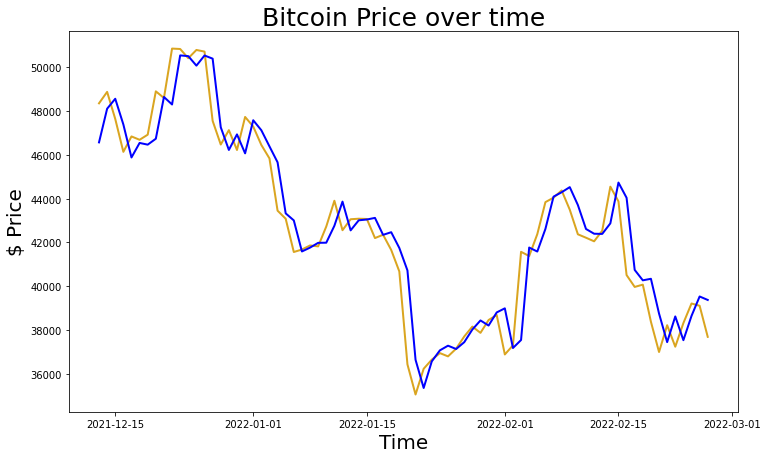

In [10]:
plt.figure(figsize = (12, 7))
plt.plot(y_result["datetime"], y_result["close_bitcoin_true"], color='goldenrod', lw=2)
plt.plot(y_result["datetime"], y_result["close_bitcoin_pred"], color='blue', lw=2)
plt.title("Bitcoin Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20)
plt.show()

In [11]:
to_predict=x_set.iloc[-1:][required_features].copy()
to_predict = scaler.transform(to_predict).copy()

prediction = model.predict(to_predict)

/Users/pingping/.pyenv/versions/3.8.12/envs/bittooth/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [12]:
tomorrow = bitcoin["datetime"].iloc[-1] + datetime.timedelta(days=1)
tmr = tomorrow.strftime("%B %d, %Y")
print("The prediction of Bitcoin price on",tmr,"at 7 P.M. is",prediction[0][0])

The prediction of Bitcoin price on February 28, 2022 at 7 P.M. is 38007.62458146972
